In [1]:

!pip install scikit-learn pandas numpy matplotlib seaborn joblib


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib, os, warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import files
uploaded = files.upload()


Saving marketing_campaign.csv to marketing_campaign.csv


In [4]:

df = pd.read_csv("/content/marketing_campaign.csv", sep=None, engine="python")

df.head(50)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


In [5]:
# Dropping irrelevant columns
drop_cols = ['ID', 'Z_CostContact', 'Z_Revenue']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

# Handling missing values
df = df.dropna(subset=['Income'])
df = df.fillna(0)

# Convert date columns
if 'Dt_Customer' in df.columns:
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
    df['Customer_Tenure'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days

# Calculate Age if Year_Birth exists
if 'Year_Birth' in df.columns:
    df['Age'] = 2025 - df['Year_Birth']


print(df.columns.tolist())

['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Customer_Tenure', 'Age']


In [6]:
# Derive total spend
spend_cols = [c for c in df.columns if "Mnt" in c or "Spend" in c]
df['Total_Spend'] = df[spend_cols].sum(axis=1)

# Select key features for clustering
crm_cols = ["Income", "Age", "Recency", "NumWebPurchases", "NumStorePurchases", "Total_Spend"]
crm_cols = [c for c in crm_cols if c in df.columns]

df_model = df[crm_cols].copy()
df_model = df_model.fillna(0)
df_model.head()


,Income,Age,Recency,NumWebPurchases,NumStorePurchases,Total_Spend
0,58138.0,68,58,8,4,1617
1,46344.0,71,38,1,2,27
2,71613.0,60,26,8,10,776
3,26646.0,41,26,2,4,53
4,58293.0,44,94,5,6,422


In [7]:
# Weight Income and Spend more heavily
weights = np.array([2.0, 0.5, 0.3, 1.0, 1.0, 2.0])[:len(crm_cols)]
X_weighted = df_model.values * weights

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_weighted)


In [8]:
#choosing number of cluster according to the data
n_clusters = min(6, max(2, X_scaled.shape[0] // 10))

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_
df['Cluster'] = labels

# Cluster size
df['Cluster'].value_counts()


,count
Cluster,
0,451
1,393
4,385
5,377
2,318
3,292


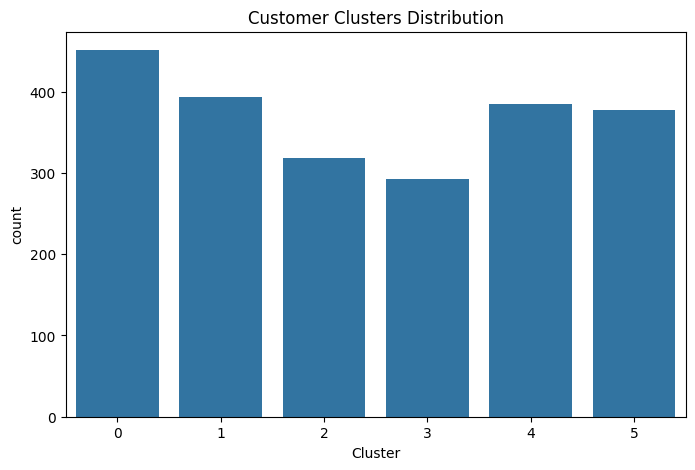

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['Cluster'])
plt.title("Customer Clusters Distribution")
plt.show()


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
acc = accuracy_score(y_test, preds)

print(f" Random Forest trained successfully — Accuracy: {acc:.3f}")


 Random Forest trained successfully — Accuracy: 0.950


In [11]:
os.makedirs("model", exist_ok=True)

joblib.dump(kmeans, "model/kmeans_model.pkl")
joblib.dump(scaler, "model/scaler.pkl")
joblib.dump(rf, "model/best_classifier.pkl")

print(" Models saved successfully in /model folder!")


 Models saved successfully in /model folder!


In [12]:
from google.colab import files
files.download("model/kmeans_model.pkl")
files.download("model/scaler.pkl")
files.download("model/best_classifier.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
df['Cluster'] = kmeans.labels_

# See average behavior per cluster
cluster_summary = df.groupby('Cluster')[['Income', 'Total_Spend', 'NumWebPurchases', 'NumStorePurchases', 'Recency']].mean().round(2)
print(cluster_summary)

           Income  Total_Spend  NumWebPurchases  NumStorePurchases  Recency
Cluster                                                                    
0        32155.23        94.69             2.00               3.11    24.68
1        68966.48      1155.89             5.93               8.49    74.86
2        78595.63      1388.12             4.86               9.06    41.15
3        41936.47       159.58             2.47               3.78    55.79
4        61202.36       801.85             6.76               7.34    24.42
5        35470.31       136.81             2.53               3.47    77.66


In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc:.3f}")


Random Forest Accuracy: 0.948
